In [1]:
print("hello world")

hello world


In [1]:
import torch

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.models.resnet import BasicBlock, ResNet
import logging
import numpy as np
from collections import OrderedDict
import functools
import wandb
import random
import os
import matplotlib.pyplot as plt
from datasources.EyediapTest import EyediapLoaderTest

from torch.utils.data import DataLoader, Subset
from datasources import EVESequences_train, EVESequences_test, EVESequences_val
from core import DefaultConfig
from torch.optim.lr_scheduler import ExponentialLR

from torch.utils.tensorboard import SummaryWriter
import time
from datetime import datetime, timezone
from model.eyenet import EyeNet
from model.eyenet_frame import EyeNetFrame
from utils.loss import BaseLossWithValidity, L1Loss, AngularLoss, EuclideanLoss
from utils.util_functions import pitchyaw_to_vector
from utils.util_functions import to_screen_coordinates, apply_rotation, apply_transformation, get_intersect_with_zero
from utils.util_functions import set_seed
from core.training import init_datasets_eval
from core import DefaultConfig, training
from datasources import EVESequencesBase, EVESequences_train, EVESequences_val, EVESequences_test  # for i,data in enumerate(test_dataloader):
from model.facenet_transformer import FaceNetTransformer
from model.face_mixste import FaceMixSTE

logger = logging.getLogger(__name__)
config = DefaultConfig()

hp = {
    'eye_net_rnn_num_features': 128,
    'eye_net_rnn_num_cells': 1,
    'batch_size': 16,
    'epoch_num': 10,
    'sequence_length': 30,
    'saving_dir': './saving',
}

def gazeto3d(gaze):
  gaze_gt = np.zeros([3])
  gaze_gt[0] = -np.cos(gaze[1]) * np.sin(gaze[0])
  gaze_gt[1] = -np.sin(gaze[1])
  gaze_gt[2] = -np.cos(gaze[1]) * np.cos(gaze[0])
  return gaze_gt

def angular(gaze, label):
  total = np.sum(gaze * label)
  return np.arccos(min(total/(np.linalg.norm(gaze)* np.linalg.norm(label)), 0.9999999))*180/np.pi


set_seed(1024)

train_dataset_paths = [
        ('eve_train', EVESequences_train, '/root/autodl-tmp/eve_dataset/eve_dataset', config.train_stimuli, config.train_cameras),  # noqa
    ]
validation_dataset_paths = [
    ('eve_val', EVESequences_val, '/root/autodl-tmp/eve_dataset/eve_dataset', config.test_stimuli, config.test_cameras),
]
train_data, test_data = init_datasets_eval(train_dataset_paths, validation_dataset_paths)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: {}".format(torch.cuda.get_device_name(device)))

# model = EyeNetFrame().to(device)
model = FaceNetTransformer().to(device)
model2 = FaceNetTransformer().to(device)
# model = FaceMixSTE().to(device)
model.load_state_dict(torch.load("/root/autodl-tmp/projects/m2ff/saving/eveframe_epoch_9_batch_2034_time_20240824_093923.pth"))
# model.load_state_dict(torch.load("/root/autodl-tmp/projects/m2ff/saving/eveframe123_epoch_9_batch_4069_time_20240830_170527.pth"))
# model2.load_state_dict(torch.load("autodl-tmp/projects/m2ff/saving/eveframe123_epoch_9_batch_4069_time_20240830_170527.pth"))
model2.load_state_dict(torch.load("/root/autodl-tmp/projects/m2ff/saving/eveframe123_epoch_9_batch_4069_time_20240831_235145.pth"))
model.eval()
model2.eval()

Using device: NVIDIA L20


FaceNetTransformer(
  (cnn_layer): MyResNet18(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (downsample1): Sequential(
      (0): Conv2d(320, 5, kernel_size=(1, 1), stride=(1, 1))
      (1): InstanceNorm2d(5, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (downsample1_1): Sequential(
      (0): Conv2d(45, 30, kernel_size=(1, 1), stride=(1, 1))
      (1): InstanceNorm2d(30, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (downsample1_1_1): Sequential(
      (0): Conv2d(45, 30, kernel_size=(1, 1), stride=(1, 1))
      (1): InstanceNorm2d(30, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
    (downsample2): Sequential(
      (0): Conv2d(640, 5, ke

In [3]:
my_dict = None

In [4]:
test_dataloader = test_data['eve_val']['dataloader']
with torch.no_grad():
    for i, test_data in enumerate(test_dataloader):
        my_dict = test_data
        break

In [5]:
for k,v in my_dict.items():
    print(k)

camera_matrix
camera_transformation
face_PoG_tobii
face_PoG_tobii_validity
face_R
face_R_validity
face_W
face_W_validity
face_g_tobii
face_g_tobii_validity
face_h
face_h_validity
face_o
face_o_validity
facial_landmarks
facial_landmarks_validity
head_rvec
head_rvec_validity
head_tvec
head_tvec_validity
inv_camera_transformation
left_PoG_tobii
left_PoG_tobii_validity
left_R
left_R_validity
left_W
left_W_validity
left_g_tobii
left_g_tobii_validity
left_h
left_h_validity
left_o
left_o_validity
left_p
left_p_validity
millimeters_per_pixel
pixels_per_millimeter
right_PoG_tobii
right_PoG_tobii_validity
right_R
right_R_validity
right_W
right_W_validity
right_g_tobii
right_g_tobii_validity
right_h
right_h_validity
right_o
right_o_validity
right_p
right_p_validity
head_R
timestamps
left_eye_patch
right_eye_patch
face_patch
participant
subfolder
camera


In [6]:
model.eval()
for k, v in my_dict.items():
    if isinstance(v, torch.Tensor):
        my_dict[k] = v.to(device)
my_dict_out = model(my_dict)
my_dict_out2 = model2(my_dict)
for k,v in my_dict_out.items():
    print(k, v.shape)
for k,v in my_dict_out2.items():
    print(k, v.shape)

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


face_g_initial torch.Size([16, 30, 2])
face_patch torch.Size([16, 30, 3, 256, 256])
face_g_tobii torch.Size([16, 30, 2])
face_PoG_tobii torch.Size([16, 30, 2])
face_PoG_cn_tobii torch.Size([16, 30, 2])
face_g_tobii_validity torch.Size([16, 30])
face_PoG_cm_initial torch.Size([16, 30, 2])
face_PoG_px_initial torch.Size([16, 30, 2])
loss_ang_face_g_initial torch.Size([])
euc_loss_face_PoG_cm_initial torch.Size([])
euc_loss_face_PoG_px_initial torch.Size([])
face_ada_loss torch.Size([])
face_weighted_ada_loss torch.Size([])
full_loss torch.Size([])
face_g_initial torch.Size([16, 30, 2])
face_patch torch.Size([16, 30, 3, 256, 256])
face_g_tobii torch.Size([16, 30, 2])
face_PoG_tobii torch.Size([16, 30, 2])
face_PoG_cn_tobii torch.Size([16, 30, 2])
face_g_tobii_validity torch.Size([16, 30])
face_PoG_cm_initial torch.Size([16, 30, 2])
face_PoG_px_initial torch.Size([16, 30, 2])
loss_ang_face_g_initial torch.Size([])
euc_loss_face_PoG_cm_initial torch.Size([])
euc_loss_face_PoG_px_initial tor

In [7]:
from scipy.spatial.distance import directed_hausdorff

In [10]:
gt_pt = my_dict_out['face_PoG_tobii'][0]
pd_pt = my_dict_out['face_PoG_px_initial'][0]
print(gt_pt.shape)
print(pd_pt.shape)

torch.Size([30, 2])
torch.Size([30, 2])


In [14]:
gt_np= gt_pt.cpu().detach().numpy()
pd_np = pd_pt.cpu().detach().numpy()

In [16]:
max(directed_hausdorff(gt_np, pd_np)[0], directed_hausdorff(pd_np, gt_np)[0])

629.1418901165313

In [17]:
directed_hausdorff(gt_np, pd_np)[0]

629.1418901165313

In [18]:
directed_hausdorff(pd_np, gt_np)[0]

128.72659358246378

In [9]:
from scipy.spatial import procrustes

In [20]:
mtx1, mtx2, disparity = procrustes(gt_np, pd_np)

In [21]:
procrustes_distance = np.sqrt(disparity)

In [22]:
print("Procrustes 距离:", procrustes_distance)

Procrustes 距离: 0.6255105457173501


In [11]:
print(my_dict_out['face_PoG_tobii'][1])
print(my_dict_out2['face_PoG_tobii'][1])

tensor([[ 969.7360,  529.1871],
        [ 965.9071,  527.7684],
        [ 966.9203,  530.3173],
        [ 970.9342,  527.2836],
        [ 968.9823,  528.6181],
        [ 970.7591,  527.6884],
        [ 966.1621,  524.0485],
        [ 968.0328,  521.9377],
        [ 966.5474,  524.9050],
        [ 965.2919,  524.1111],
        [ 966.9532,  521.0402],
        [ 962.9180,  524.4426],
        [ 964.1739,  522.5945],
        [ 965.7993,  526.2162],
        [ 965.0922,  527.3137],
        [ 856.5170,  582.4809],
        [ 819.5152,  603.8649],
        [ 545.2582,  677.6519],
        [ 540.9787,  675.8602],
        [ 539.2830,  675.6647],
        [ 563.5544,  690.4573],
        [ 496.7879,  355.6154],
        [ 499.7967,  276.5044],
        [ 500.9214,  278.7440],
        [ 521.4608,  288.7889],
        [ 628.6332,  344.6104],
        [ 957.6646,  412.3433],
        [ 963.9147,  414.9264],
        [1081.2899,  440.8860],
        [1088.2476,  441.2326]], device='cuda:0')
tensor([[ 969.7360,  5

In [13]:
print(my_dict_out['face_PoG_px_initial'][1])
print(my_dict_out2['face_PoG_px_initial'][1])

tensor([[833.7090, 430.6573],
        [822.0540, 455.3844],
        [828.6682, 444.0623],
        [830.8364, 444.3484],
        [825.9351, 440.3666],
        [828.8549, 437.7048],
        [827.2510, 439.0226],
        [838.2925, 437.2596],
        [832.4091, 434.1820],
        [839.4620, 466.3919],
        [844.7567, 491.4624],
        [829.9063, 493.4623],
        [850.0064, 510.3502],
        [837.2225, 495.3945],
        [847.5966, 495.1422],
        [828.4178, 519.5770],
        [633.8652, 633.0690],
        [459.7032, 663.8625],
        [430.5776, 656.9608],
        [461.5910, 639.8713],
        [478.5649, 631.6704],
        [356.3136, 381.2505],
        [427.2992, 248.8433],
        [439.5258, 217.8647],
        [477.5853, 273.8115],
        [573.2698, 343.6135],
        [807.3272, 435.0092],
        [877.5343, 425.7126],
        [888.7418, 419.2215],
        [988.9790, 437.9816]], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[831.1697, 431.5883],
        [819.9370, 456.99

In [14]:
gt  = my_dict_out['face_PoG_tobii'][1].cpu().detach().numpy()
pd1 = my_dict_out['face_PoG_px_initial'][1].cpu().detach().numpy()
pd2 = my_dict_out2['face_PoG_px_initial'][1].cpu().detach().numpy()

In [16]:
mtx11, mtx21, disparity1 = procrustes(gt, pd1)
mtx12, mtx22, disparity2 = procrustes(gt, pd2)
p1 = np.sqrt(disparity1)
p2 = np.sqrt(disparity2)
print(p1, p2)

0.22553710003230604 0.2239434776267769


In [10]:
mean_p1 = 0
mean_p2 = 0
for i in range(16):
    gt = my_dict_out['face_PoG_tobii'][i].cpu().detach().numpy()
    pd1 = my_dict_out['face_PoG_px_initial'][i].cpu().detach().numpy()
    pd2 = my_dict_out2['face_PoG_px_initial'][i].cpu().detach().numpy()
    mtx11, mtx21, disparity1 = procrustes(gt, pd1)
    mtx12, mtx22, disparity2 = procrustes(gt, pd2)
    p1 = np.sqrt(disparity1)
    p2 = np.sqrt(disparity2)
    mean_p1 += p1
    mean_p2 += p2
    print(p1, p2)

print("mean")
print(mean_p1, mean_p2)

0.7053058499069527 0.72663462666285
0.22553710003230604 0.2009996582772439
0.8501844024707235 0.8756085989512191
0.2177110908398328 0.18494227645965808
0.6899802173984074 0.6768966443670482
0.955616595092111 0.950945074711611
0.1807821076992395 0.15188482321012226
0.2696772273055389 0.2856381471648271
0.6475519522821103 0.5830245991926466
0.8295394492753508 0.8400753343875637
0.03983051527835756 0.03595724320637568
0.14962361077742742 0.16916528863649655
0.15128718498863938 0.1436546526338645
0.9212583967512143 0.9427640155097615
0.747980173790694 0.8139347398086481
0.2566768421779773 0.22378138071208822
mean
7.838542716066883 7.805907103892025


In [2]:
from scipy.spatial import procrustes
test_dataloader = test_data['eve_val']['dataloader']
p1_small = 0
p2_small = 0
p1_all = 0
p2_all = 0
pda1_all = 0
pda2_all = 0
g1_all = 0
g2_all = 0

with torch.no_grad():
    for b, test_data in enumerate(test_dataloader):
        if b == 477:
            break
        my_dict = test_data
        for k, v in my_dict.items():
            if isinstance(v, torch.Tensor):
                my_dict[k] = v.to(device)
        my_dict_out = model(my_dict)
        my_dict_out2 = model2(my_dict)
        mean_p1 = 0
        mean_p2 = 0
        pda1 = my_dict_out['face_ada_loss'].item()
        pda2 = my_dict_out2['face_ada_loss'].item()
        g1 = my_dict_out['loss_ang_face_g_initial'].item()
        g2 = my_dict_out2['loss_ang_face_g_initial'].item()
        for i in range(my_dict_out['face_PoG_tobii'].shape[0]):
            gt = my_dict_out['face_PoG_tobii'][i].cpu().detach().numpy()
            pd1 = my_dict_out['face_PoG_px_initial'][i].cpu().detach().numpy()
            pd2 = my_dict_out2['face_PoG_px_initial'][i].cpu().detach().numpy()
            mtx11, mtx21, disparity1 = procrustes(gt, pd1)
            mtx12, mtx22, disparity2 = procrustes(gt, pd2)
            p1 = np.sqrt(disparity1)
            p2 = np.sqrt(disparity2)
            if p1 < p2:
                p1_small += 1
            else:
                p2_small += 1
            mean_p1 += p1
            mean_p2 += p2
        p1_all += mean_p1
        p2_all += mean_p2
        pda1_all += pda1
        pda2_all += pda2
        g1_all += g1
        g2_all += g2
        print(b, mean_p1, mean_p2, p1_all, p2_all, p1_small, p2_small, pda1_all, pda2_all, g1_all, g2_all)
print(p1_all)
print(p2_all)
print(p1_small)
print(p2_small)
print(pda1_all)
print(pda2_all)
print(g1_all)
print(g2_all)

            
        
            

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


0 7.83851132594287 7.824789124122214 7.83851132594287 7.824789124122214 7 9 0.7022323608398438 1.2843399047851562 3.2979564666748047 3.387002944946289
1 7.700251465660844 7.605520027042052 15.538762791603713 15.430309151164266 18 14 2.498779296875 3.0802154541015625 6.5035810470581055 6.946113586425781
2 8.668426398127417 8.982244997726323 24.20718918973113 24.41255414889059 29 19 5.6131744384765625 5.541969299316406 9.4417724609375 9.895172834396362
3 5.235085893664704 5.469794516333058 29.442275083395835 29.882348665223645 38 26 9.449615478515625 8.517280578613281 12.364258766174316 12.604583024978638
4 5.736371724610792 5.9931061211941525 35.178646808006626 35.8754547864178 50 30 11.387229919433594 9.243705749511719 15.004632949829102 15.606791973114014
5 9.136117814443828 9.085047883440078 44.314764622450454 44.960502669857874 60 36 15.185371398925781 13.328865051269531 18.584209442138672 19.128528118133545
6 7.423447862395856 7.7681310037493825 51.73821248484631 52.728633673607256

In [3]:
3561+15    +4071+44-15
28.6566773461
28.6115487617

7676

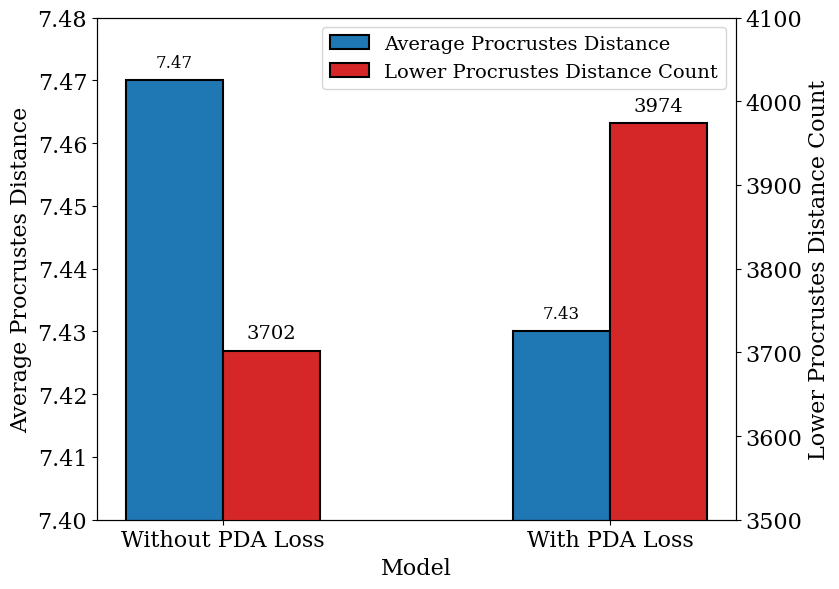

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Set the font to a serif font that is similar to Times New Roman
plt.rcParams['font.family'] = 'serif'

# Data
labels = ['Without PDA Loss', 'With PDA Loss']
average_procrustes_distances = [7.47, 7.43]
lower_procrustes_count = [3702, 3974]

# Correct error margins
procrustes_errors = [0.0025, 0.004]  # Actual errors for Procrustes distance
count_errors = [15, 15]  # Actual errors for count

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

# Adjusting the figure size for a single column in a two-column paper
fig, ax1 = plt.subplots(figsize=(8.5, 6))

# Plotting the average Procrustes distances (left y-axis) with error bars
ax1.set_xlabel('Model', color='black', fontsize=16)
ax1.set_ylabel('Average Procrustes Distance', color='black', fontsize=16)
bars1 = ax1.bar(x - width/2, average_procrustes_distances, width, label='Average Procrustes Distance',
                color='tab:blue', capsize=18, edgecolor='black', linewidth=1.5)
ax1.tick_params(axis='y', labelcolor='black', labelsize=16)
ax1.tick_params(axis='x', labelcolor='black', labelsize=16)

# Adding data labels on the bars for average Procrustes distances
for bar, error in zip(bars1, procrustes_errors):
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.0015, round(yval, 3), ha='center', va='bottom', color='black', fontsize=12)

# Creating the second y-axis for the lower Procrustes distance counts with error bars
ax2 = ax1.twinx()
ax2.set_ylabel('Lower Procrustes Distance Count', color='black', fontsize=16)
bars2 = ax2.bar(x + width/2, lower_procrustes_count, width, label='Lower Procrustes Distance Count',
                color='tab:red', capsize=18, edgecolor='black', linewidth=1.5)
ax2.tick_params(axis='y', labelcolor='black', labelsize=16)

# Adding data labels on the bars for lower Procrustes distance counts
for bar, error in zip(bars2, count_errors):
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom', color='black', fontsize=14)

# Scaling the y-axes for better visual differentiation
ax1.set_ylim(7.40, 7.48)
ax2.set_ylim(3500, 4100)

# Adding titles and labels
ax1.set_xticks(x)
ax1.set_xticklabels(labels, color='black', fontsize=16)

# Adding a legend
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes, fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()


In [78]:
!pip install seaborn


Looking in indexes: http://mirrors.aliyun.com/pypi/simple
  Using cached http://mirrors.aliyun.com/pypi/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl (294 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 137.2 kB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 137.5 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 140.0 kB/s eta 0:00:0000:0100:01


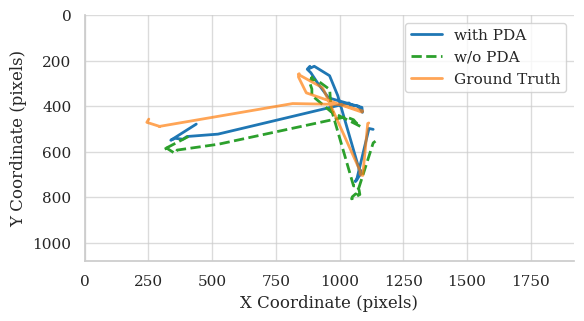

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 使用 seaborn 的配色方案
sns.set(style="whitegrid")

p = 15
pred = my_dict_out['face_PoG_px_initial'][p]
pred2 = my_dict_out2['face_PoG_px_initial'][p]
gt = my_dict_out['face_PoG_tobii'][p]

# 假设屏幕分辨率为 1920x1080
screen_width = 1920
screen_height = 1080
plt.rcParams['font.family'] = 'serif'

# 从 tensor 转换为 numpy 数组，如果它们还不是 numpy 数组
pred_points = pred.cpu().detach().numpy() if hasattr(pred, 'numpy') else pred
pred2_points = pred2.cpu().detach().numpy() if hasattr(pred, 'numpy') else pred
gt_points = gt.cpu().detach().numpy() if hasattr(gt, 'numpy') else gt

# 过滤掉 gt 中的 (0, 0) 点，同时过滤 pred 和 pred2 中对应的点
valid_gt_indices = ~(np.all(gt_points == 0, axis=1))
filtered_gt_points = gt_points[valid_gt_indices]
filtered_pred_points = pred_points[valid_gt_indices]
filtered_pred2_points = pred2_points[valid_gt_indices]

# 创建一个新的图形，调整比例，使其符合常见的论文图表尺寸
plt.figure(figsize=(6, 3.375))

# 绘制过滤后的预测的线条，并调整线条样式
plt.plot(filtered_pred_points[:, 0], filtered_pred_points[:, 1], c='#1f77b4', linestyle='-', linewidth=2, label='with PDA')
plt.plot(filtered_pred2_points[:, 0], filtered_pred2_points[:, 1], c='#2ca02c', linestyle='--', linewidth=2, label='w/o PDA')

# 绘制过滤后的真实值的线条，并设置透明度
plt.plot(filtered_gt_points[:, 0], filtered_gt_points[:, 1], c='#ff7f0e', linestyle='-', linewidth=2, alpha=0.7, label='Ground Truth')

# 设置屏幕的大小限制
plt.xlim(0, screen_width)
plt.ylim(0, screen_height)

# 翻转 y 轴，以使 (0, 0) 位于左上角
plt.gca().invert_yaxis()

# 添加网格线
plt.grid(True, linestyle='-', alpha=0.7)

# 去掉顶部和右侧边框
sns.despine()

# 调整图例位置
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))

# 添加标题和标签
plt.xlabel('X Coordinate (pixels)', fontsize=12)
plt.ylabel('Y Coordinate (pixels)', fontsize=12)

# 显示图形
plt.tight_layout()
plt.show()


In [ ]:
batch 0: 10 12 14 15 6(虽然离得远，但是更像) 

In [2]:
from scipy.spatial import procrustes
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
p1_all = 0
p2_all = 0
count = 0

test_dataloader = test_data['eve_val']['dataloader']
with torch.no_grad():
    for b, test_data in enumerate(test_dataloader):
        if b == 477:
            break
        my_dict = test_data
        for k, v in my_dict.items():
            if isinstance(v, torch.Tensor):
                my_dict[k] = v.to(device)
        my_dict_out = model(my_dict)
        my_dict_out2 = model2(my_dict)
        p1_past = p1_all
        p2_past = p2_all
        for i in range(16):
            pred = my_dict_out['face_PoG_px_initial'][i]
            pred2 = my_dict_out2['face_PoG_px_initial'][i]
            gt = my_dict_out['face_PoG_tobii'][i]

            # 假设屏幕分辨率为 1920x1080
            screen_width = 1920
            screen_height = 1080
            plt.rcParams['font.family'] = 'serif'
            
            # 从 tensor 转换为 numpy 数组，如果它们还不是 numpy 数组
            pred_points = pred.cpu().detach().numpy() if hasattr(pred, 'numpy') else pred
            pred2_points = pred2.cpu().detach().numpy() if hasattr(pred, 'numpy') else pred
            gt_points = gt.cpu().detach().numpy() if hasattr(gt, 'numpy') else gt

            # 过滤掉 gt 中的 (0, 0) 点，同时过滤 pred 和 pred2 中对应的点
            valid_gt_indices = ~(np.all(gt_points == 0, axis=1))
            filtered_gt_points = gt_points[valid_gt_indices]
            filtered_pred_points = pred_points[valid_gt_indices]
            filtered_pred2_points = pred2_points[valid_gt_indices]

            # 计算普氏距离
            mtx11, mtx21, disparity1 = procrustes(filtered_gt_points, filtered_pred_points)
            mtx12, mtx22, disparity2 = procrustes(filtered_gt_points, filtered_pred2_points)

            p1 = np.sqrt(disparity1)
            p2 = np.sqrt(disparity2)

#             count += 1
#             p1_all += p1
#             p2_all += p2
#         print(b, p1_all - p1_past, p2_all-p2_past, p1_all, p2_all)
# p1_mean = p1_all / count
# p2_mean = p2_all / count
# print(p1_mean, p2_mean)


            
            # 创建一个新的图形，调整比例，使其符合常见的论文图表尺寸
            plt.figure(figsize=(6, 3.375))
            
            # 绘制过滤后的预测的线条，并调整线条样式
            plt.plot(filtered_pred_points[:, 0], filtered_pred_points[:, 1], c='#1f77b4', linestyle='-', linewidth=2, label='with PDA')
            plt.plot(filtered_pred2_points[:, 0], filtered_pred2_points[:, 1], c='#2ca02c', linestyle='--', linewidth=2, label='w/o PDA')
            
            # 绘制过滤后的真实值的线条，并设置透明度
            plt.plot(filtered_gt_points[:, 0], filtered_gt_points[:, 1], c='#ff7f0e', linestyle='-', linewidth=2, alpha=0.7, label='Ground Truth')
            
            # 设置屏幕的大小限制
            plt.xlim(0, screen_width)
            plt.ylim(0, screen_height)
            
            # 翻转 y 轴，以使 (0, 0) 位于左上角
            plt.gca().invert_yaxis()
            
            # 添加网格线
            plt.grid(True, linestyle='-', alpha=0.7)
            
            # 去掉顶部和右侧边框
            sns.despine()
            
            # 调整图例位置
            plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
            
            # 在图的左上角添加普氏距离的标注
            plt.text(10, 50, f'p1: {p1:.4f}', fontsize=10, verticalalignment='top', horizontalalignment='left')
            plt.text(10, 120, f'p2: {p2:.4f}', fontsize=10, verticalalignment='top', horizontalalignment='left')

            # 添加标题和标签
            plt.xlabel('X Coordinate (pixels)', fontsize=12)
            plt.ylabel('Y Coordinate (pixels)', fontsize=12)
            
            # 显示图形
            plt.tight_layout()
            print(b, i)
            plt.show()


/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


0 3.8484683723512854 3.959099440498528 3.8484683723512854 3.959099440498528
1 3.7435858885195854 3.7593037829881664 7.592054260870871 7.718403223486694
2 4.384765890760603 4.654083165423703 11.976820151631474 12.372486388910398
3 3.651620414094923 3.8284631418289568 15.628440565726397 16.200949530739354
4 3.2311277397689686 3.3270996065177876 18.859568305495365 19.528049137257142
5 4.731591089194836 4.713055207228592 23.5911593946902 24.241104344485734
6 4.725590152056263 5.116151358139241 28.316749546746465 29.357255702624975
7 4.1376477039799795 4.5706547612599735 32.454397250726444 33.92791046388495
8 4.572949430377868 4.513442305368891 37.02734668110431 38.44135276925384
9 3.3086682671539336 3.240340291427806 40.336014948258246 41.681693060681646
10 3.956617977086914 4.047567269510232 44.29263292534516 45.72926033019188
11 4.3806206102171 4.293071668494171 48.67325353556226 50.02233199868605
12 3.697073003991129 3.6928068817206423 52.37032653955339 53.71513888040669
13 4.2178218624

In [ ]:
0 3.8484683723512854 3.959099440498528 3.8484683723512854 3.959099440498528
1 3.7435858885195854 3.7593037829881664 7.592054260870871 7.718403223486694
2 4.384765890760603 4.654083165423703 11.976820151631474 12.372486388910398
3 3.651620414094923 3.8284631418289568 15.628440565726397 16.200949530739354
4 3.2311277397689686 3.3270996065177876 18.859568305495365 19.528049137257142
5 4.731591089194836 4.713055207228592 23.5911593946902 24.241104344485734
6 4.725590152056263 5.116151358139241 28.316749546746465 29.357255702624975
7 4.1376477039799795 4.5706547612599735 32.454397250726444 33.92791046388495
8 4.572949430377868 4.513442305368891 37.02734668110431 38.44135276925384
9 3.3086682671539336 3.240340291427806 40.336014948258246 41.681693060681646
10 3.956617977086914 4.047567269510232 44.29263292534516 45.72926033019188
11 4.3806206102171 4.293071668494171 48.67325353556226 50.02233199868605
12 3.697073003991129 3.6928068817206423 52.37032653955339 53.71513888040669
13 4.21782186246304 4.229552642727192 56.58814840201643 57.94469152313388
14 4.6132468729999445 4.830952709509887 61.201395275016374 62.77564423264377
15 4.813756930713815 4.93910549924054 66.01515220573019 67.71474973188431
16 4.61856393850077 4.632430354273225 70.63371614423096 72.34718008615754
17 3.4849910523076204 3.4386793396034676 74.11870719653858 75.785859425761
18 3.655736207096325 4.008710051988487 77.7744434036349 79.79456947774949
19 4.486649032939084 4.521849430583472 82.26109243657399 84.31641890833296
20 4.088655087053326 3.8262747013330056 86.34974752362731 88.14269360966597
21 5.543921732815946 5.352203793936283 91.89366925644326 93.49489740360225
22 4.643207742012905 4.500378083187272 96.53687699845617 97.99527548678952
23 4.8157939908662115 4.510079859739719 101.35267098932238 102.50535534652924
24 3.774248925051964 3.8343290432685393 105.12691991437434 106.33968438979778
25 3.8770660962580052 3.852385588557894 109.00398601063235 110.19206997835568
26 3.729944490310743 3.7922452086489784 112.73393050094309 113.98431518700465
27 3.084840093879393 3.0247411446533192 115.81877059482248 117.00905633165797
28 4.354858563162352 4.51195844877185 120.17362915798483 121.52101478042982
29 2.9384392797309857 2.949706735889606 123.11206843771582 124.47072151631943
30 4.731365587482657 4.245350763575459 127.84343402519848 128.7160722798949
31 3.5446644028060206 3.5157102453312348 131.3880984280045 132.23178252522612
32 4.009044444733718 4.121856274851439 135.39714287273821 136.35363880007756
33 4.7644570559784825 4.646372769869572 140.1615999287167 141.00001156994713
34 3.204532769307491 3.403861141932879 143.3661326980242 144.40387271188
35 3.3999637744695406 3.482055543046414 146.76609647249373 147.88592825492643
36 4.379454037092216 4.124319646399499 151.14555050958595 152.01024790132593
37 4.860180528355215 4.9590845639212375 156.00573103794116 156.96933246524716
38 4.595652616002184 4.578466382248081 160.60138365394334 161.54779884749524
39 4.323388613646358 4.147989201489111 164.9247722675897 165.69578804898435
40 4.277318089437699 4.427128686552152 169.2020903570274 170.1229167355365
41 3.6019800326192524 3.9780654812364276 172.80407038964665 174.10098221677293
42 6.708658507084095 6.652934638308892 179.51272889673075 180.75391685508183
43 4.34622316312786 4.265682900351152 183.8589520598586 185.01959975543298
44 4.861475125367747 4.725569990065395 188.72042718522636 189.74516974549837
45 4.039051030498058 3.825212844198603 192.7594782157244 193.57038258969698
46 5.936213110182393 5.911410307725504 198.6956913259068 199.48179289742248
47 3.6824460241365955 3.7755510471331775 202.3781373500434 203.25734394455566
48 3.7461344540290042 3.765613218973158 206.1242718040724 207.02295716352882
49 3.149927960775557 3.046769388579463 209.27419976484796 210.06972655210828
50 3.4919068890683604 3.5788500637234506 212.76610665391632 213.64857661583173
51 4.541159974920561 4.367644815828157 217.30726662883689 218.0162214316599
52 4.5922661432086045 4.801048273114219 221.8995327720455 222.8172697047741
53 4.128430250385492 4.262026051364813 226.02796302243098 227.07929575613892
54 4.637842591395696 4.831642931995674 230.66580561382668 231.9109386881346
55 3.6411273480429998 3.313195382723194 234.30693296186968 235.2241340708578
56 3.0894077269191484 3.126342803061931 237.39634068878883 238.35047687391972
57 4.908105700522242 4.864837804258514 242.30444638931107 243.21531467817823
58 2.623069993173658 2.8074671832591207 244.92751638248473 246.02278186143735
59 3.497738637441273 3.529313790521428 248.425255019926 249.55209565195878
60 3.4571026195189063 3.5609386335964075 251.8823576394449 253.1130342855552
61 3.5189816260645443 3.7941108939334924 255.40133926550945 256.9071451794887
62 3.6545850110662457 3.7105605489990126 259.0559242765757 260.6177057284877
63 3.1923087268945665 3.1497288135870463 262.24823300347026 263.76743454207474
64 5.33632450412739 5.618631436927558 267.58455750759765 269.3860659790023
65 2.896908280121295 2.962761339750614 270.48146578771895 272.3488273187529
66 3.5767891810837114 3.761986283230044 274.05825496880266 276.11081360198295
67 3.745830186874457 3.723062301349387 277.8040851556771 279.83387590333234
68 3.9942683197694464 4.127366726369189 281.79835347544656 283.96124262970153
69 3.864734631368947 4.0994672470760065 285.6630881068155 288.06070987677754
70 3.582889376435844 3.532849668284996 289.24597748325135 291.59355954506253
71 3.322362740866822 3.5320805902543384 292.5683402241182 295.12564013531687
72 2.981449094390257 3.1725898490695954 295.54978931850843 298.29822998438647
73 2.971612772393769 2.899116135668919 298.5214020909022 301.1973461200554
74 4.604466975410446 4.616402119547331 303.12586906631265 305.8137482396027
75 4.021350331777626 3.9679961107325425 307.1472193980903 309.78174435033526
76 5.0403982086794485 5.172846027737762 312.1876176067697 314.954590378073
77 3.4213347999540815 3.5442467288157786 315.6089524067238 318.4988371068888
78 3.7938378247259266 3.7755458631136776 319.4027902314497 322.2743829700025
79 4.223866234128991 4.703808801967114 323.6266564655787 326.9781917719696
80 4.378758703330391 5.000056641728293 328.0054151689091 331.9782484136979
81 4.437082354254812 4.443434395937118 332.4424975231639 336.421682809635
82 5.3080028972965465 5.314293995094147 337.75050042046047 341.73597680472915
83 4.2720585141899505 4.100360325513861 342.0225589346504 345.836337130243
84 4.32979381575359 4.536540288643948 346.352352750404 350.37287741888696
85 4.640070713883858 4.2846931924424325 350.99242346428787 354.6575706113294
86 5.282169049286438 4.364825647459554 356.2745925135743 359.02239625878894
87 3.3722017680191243 3.6868713292355437 359.64679428159343 362.7092675880245
88 4.3163502955456465 4.413145407876527 363.9631445771391 367.122412995901
89 3.1024500276334948 3.269483972289777 367.06559460477257 370.3918969681908
90 3.5371894820875696 3.579543775404204 370.60278408686014 373.971440743595
91 3.806382918690531 3.9398915090981745 374.40916700555067 377.91133225269317
92 4.81576885604278 5.310566903464519 379.22493586159345 383.2218991561577
93 3.8784175595575334 4.138266919313651 383.103353421151 387.36016607547134
94 4.339265322120923 4.018871130936532 387.4426187432719 391.3790372064079
95 4.069168916391959 4.145645372287618 391.51178765966387 395.5246825786955
96 5.992164623131828 5.6610479700322 397.5039522827957 401.1857305487277
97 3.7331341472681174 3.656002832123704 401.2370864300638 404.8417333808514
98 4.057463968860702 4.313424321865284 405.2945503989245 409.1551577027167
99 4.215366409439355 4.136274683346983 409.50991680836387 413.29143238606366
100 3.587647036389342 3.7984889422004926 413.0975638447532 417.08992132826415
101 4.817761238865899 4.688790640275954 417.9153250836191 421.7787119685401
102 4.331727198299575 4.623694754640326 422.2470522819187 426.40240672318043
103 4.805911109393946 4.941042171991114 427.05296339131263 431.34344889517155
104 4.43867317628883 4.4462408810917395 431.49163656760146 435.7896897762633
105 3.680056873179126 3.5398230027956856 435.1716934407806 439.329512779059
106 3.7766318688914566 3.926422857087175 438.94832530967204 443.25593563614615
107 5.1501892810382515 4.696473379491749 444.0985145907103 447.9524090156379
108 4.664959512659493 4.681403162178924 448.7634741033698 452.6338121778168
109 4.176644320755372 4.601634672327691 452.94011842412516 457.2354468501445
110 4.1415702108226355 3.9894041668745217 457.0816886349478 461.22485101701903
111 4.549004289407208 4.892201441447526 461.630692924355 466.11705245846656
112 4.4004474482457 4.267464551471448 466.0311403726007 470.384517009938
113 3.735188930704055 3.591539650402467 469.76632930330476 473.9760566603405
114 4.418309316308353 4.91710200193512 474.1846386196131 478.8931586622756
115 4.197437061435039 4.276443440854564 478.38207568104815 483.16960210313016
116 4.706422658946906 4.877730055452162 483.08849833999506 488.0473321585823
117 4.129458770994631 4.305879944027026 487.2179571109897 492.35321210260935
118 3.2309331648986017 3.3507975690833405 490.4488902758883 495.7040096716927
119 3.00096770334585 3.0749642446225494 493.44985797923414 498.77897391631524
120 3.559286062952367 3.761619687630798 497.0091440421865 502.54059360394604
121 4.911600355744213 4.78611034387842 501.9207443979307 507.32670394782446
122 3.802392331877968 3.883885728002042 505.7231367298087 511.2105896758265
123 3.9666258537455406 3.8200130438438578 509.6897625835542 515.0306027196704
124 3.6248234154718944 3.584352359828813 513.3145859990261 518.6149550794992
125 3.3629713235129657 3.5210729673295873 516.6775573225391 522.1360280468288
126 3.485307875116291 3.484274991159964 520.1628651976554 525.6203030379887
127 4.2317233114901 3.787993510784986 524.3945885091455 529.4082965487737
128 3.6727967021986387 3.4885514446656316 528.0673852113441 532.8968479934393
129 3.64888483068205 3.6594862247893616 531.7162700420262 536.5563342182287
130 4.369757466661326 4.512794073924169 536.0860275086875 541.0691282921529
131 5.134389921827278 5.289854123749137 541.2204174305148 546.358982415902
132 4.593891137368928 4.768334903077289 545.8143085678837 551.1273173189793
133 3.8312446015052046 3.8332772003751643 549.6455531693889 554.9605945193545
134 4.149629973065089 4.294278225682206 553.795183142454 559.2548727450367
135 3.5739245514469076 3.6716763295265764 557.3691076939009 562.9265490745632
136 5.26491391372133 5.654350911338838 562.6340216076222 568.5808999859021
137 3.024530373852599 3.2179974212194793 565.6585519814748 571.7988974071216
138 4.1087054531673175 4.053969257791664 569.7672574346421 575.8528666649132
139 3.1847384110295707 3.4620465791747392 572.9519958456717 579.314913244088
140 3.971146754570327 3.8346974055523333 576.923142600242 583.1496106496403
141 4.020968648890175 4.008875493919959 580.9441112491322 587.1584861435603
142 4.786103592040149 5.167521300313069 585.7302148411724 592.3260074438733
143 5.936895064679561 6.079689597858874 591.6671099058519 598.4056970417322
144 3.607966313989891 3.8480003527774898 595.2750762198418 602.2536973945097
145 3.361287044704909 3.7171219135249203 598.6363632645467 605.9708193080346
146 5.704962391134245 5.282468288839027 604.341325655681 611.2532875968736
147 5.309167217143454 5.2488838722197215 609.6504928728244 616.5021714690934
148 3.820179964190629 3.722384515596559 613.4706728370151 620.2245559846899
149 3.491478784252422 3.591991010616539 616.9621516212675 623.8165469953065
150 3.272023810271776 3.096332465481396 620.2341754315393 626.9128794607878
151 4.793324692887836 4.973833222219696 625.0275001244271 631.8867126830075
152 3.096919281977762 3.1315008610403083 628.1244194064049 635.0182135440479
153 5.6138619297069 5.5480286334834545 633.7382813361118 640.5662421775313
154 5.021356965150062 4.87280409354787 638.7596383012618 645.4390462710792
155 3.754350126681402 3.584952437232687 642.5139884279432 649.0239987083119
156 3.8216240836439965 3.620433081581382 646.3356125115872 652.6444317898932
157 3.479478065426065 3.3176873228236445 649.8150905770133 655.9621191127169
158 4.872679885330058 4.7911479432690385 654.6877704623433 660.7532670559859
159 3.945430635212233 3.965670889648436 658.6332010975556 664.7189379456344
160 3.45102451555033 3.251221178604851 662.0842256131059 667.9701591242392
161 3.7237958324019473 3.7677270942240284 665.8080214455078 671.7378862184632
162 4.388749934633097 4.294252213408981 670.196771380141 676.0321384318722
163 4.1923224613611865 3.852536181752157 674.3890938415021 679.8846746136244
164 4.221695046528112 4.217883735796477 678.6107888880302 684.1025583494209
165 3.6621723850772696 3.8393607819033377 682.2729612731075 687.9419191313242
166 4.457443982293739 4.544462604500723 686.7304052554013 692.4863817358249
167 4.472166401225536 4.850247427751015 691.2025716566268 697.3366291635759
168 3.662461107044578 3.9148123106332378 694.8650327636714 701.2514414742092
169 5.0529895052524125 4.954263236309544 699.9180222689238 706.2057047105187
170 3.576506454644573 3.5591793697301455 703.4945287235684 709.7648840802489
171 4.205391815889584 4.467901666123225 707.6999205394579 714.2327857463721
172 5.287618395458026 5.3888091874505335 712.987538934916 719.6215949338226
173 4.957072074814846 5.005960710828731 717.9446110097308 724.6275556446514
174 5.042227889239484 4.768488414299895 722.9868388989703 729.3960440589512
175 3.6051713120905333 3.8040585502972135 726.5920102110608 733.2001026092485
176 5.076597150763064 5.119493904469323 731.6686073618239 738.3195965137178
177 4.784103391970461 4.767315640383458 736.4527107537943 743.0869121541012
178 3.972370143747753 3.9284383160849075 740.4250808975421 747.0153504701861
179 3.9347405113318246 4.1730129878644675 744.3598214088739 751.1883634580506
180 4.259826690620116 3.9314146984742138 748.619648099494 755.1197781565248
181 5.023809838356215 5.004712544116501 753.6434579378503 760.1244907006413
182 4.955438818421499 5.45114129529793 758.5988967562718 765.5756319959393
183 3.867204574473817 3.9104288747198552 762.4661013307456 769.4860608706591
184 4.555792446673422 4.968318306029346 767.021893777419 774.4543791766885
185 3.453568395987304 3.441463984439565 770.4754621734063 777.895843161128
186 4.109090964895131 4.268181871559136 774.5845531383014 782.1640250326872
187 3.759932531407003 3.8667104581908234 778.3444856697084 786.030735490878
188 4.44792002997599 4.272717095125927 782.7924056996844 790.3034525860039
189 3.5424815338257076 3.721217884193379 786.3348872335101 794.0246704701973
190 4.382788759546088 4.445012600926702 790.7176759930562 798.469683071124
191 3.907393958841567 4.039066675597496 794.6250699518978 802.5087497467215
192 3.8191040026824794 4.076772616587618 798.4441739545803 806.5855223633091
193 4.16355962760872 4.335501252363883 802.607733582189 810.921023615673
194 4.525249354858147 4.770132491704203 807.1329829370471 815.6911561073772
195 3.5381604269593936 3.3334182905249463 810.6711433640065 819.0245743979021
196 3.883955801162301 4.053485267614519 814.5550991651688 823.0780596655167
197 3.2722460086960155 3.1871013537736417 817.8273451738648 826.2651610192903
198 3.890027416305884 3.837349564366832 821.7173725901707 830.1025105836571
199 5.3414915369404525 4.836969754391703 827.0588641271112 834.9394803380488
200 3.3664320996673496 3.5475041567030985 830.4252962267785 838.4869844947519
201 4.286091237909886 4.344145795011286 834.7113874646884 842.8311302897632
202 3.5545069449178754 3.3536228062897635 838.2658944096063 846.184753096053
203 4.554089986789904 4.1821737881675745 842.8199843963962 850.3669268842206
204 3.804256603832073 3.792965108602857 846.6242410002283 854.1598919928234
205 4.466265332081889 4.073714229064194 851.0905063323102 858.2336062218876
206 3.9927428515374004 4.027392633698355 855.0832491838476 862.260998855586
207 5.18190501891354 5.217435563112645 860.2651542027611 867.4784344186986
208 5.108282852964635 4.887122802557201 865.3734370557257 872.3655572212558
209 3.715985765861774 3.6144870901506465 869.0894228215875 875.9800443114065
210 5.041186163507518 4.899008514088791 874.130608985095 880.8790528254953
211 4.631421483324971 4.4629333410553045 878.76203046842 885.3419861665506
212 3.8355647673388376 3.734450818738651 882.5975952357588 889.0764369852892
213 3.928468092996809 4.315885973322793 886.5260633287556 893.392322958612
214 3.6212100672364613 3.855772948198023 890.1472733959921 897.24809590681
215 4.089835080730722 4.229863990740682 894.2371084767228 901.4779598975507
216 4.262534973031393 4.54320673990901 898.4996434497542 906.0211666374597
217 4.840316213739698 4.764739068952508 903.3399596634939 910.7859057064122
218 4.8328261475180625 4.464888009664151 908.172785811012 915.2507937160764
219 4.042875595341457 4.294190813117325 912.2156614063534 919.5449845291937
220 3.6614174008358304 3.797146610244681 915.8770788071893 923.3421311394384
221 3.1613938203612406 3.1199574982674676 919.0384726275505 926.4620886377058
222 3.068251141851306 2.9417682945124852 922.1067237694018 929.4038569322183
223 4.151429419231704 4.041459030182182 926.2581531886335 933.4453159624005
224 4.048481476599363 3.7461757120158836 930.3066346652329 937.1914916744164
225 4.449641768806714 4.589875430557981 934.7562764340396 941.7813671049744
226 4.247184383244075 4.24095302684259 939.0034608172837 946.022320131817
227 4.038725555519704 3.7684021325112553 943.0421863728034 949.7907222643282
228 3.608221430019057 3.608584060115618 946.6504078028224 953.3993063244438
229 5.976654247603506 5.927926276899598 952.6270620504259 959.3272326013434
230 4.484243971053502 4.488146945899189 957.1113060214794 963.8153795472426
231 3.9323477948641994 3.960515848541718 961.0436538163436 967.7758953957843
232 3.5613918724185396 3.6763752220945207 964.6050456887622 971.4522706178789
233 4.433821730882983 4.129439935499136 969.0388674196452 975.581710553378
234 5.075513144110232 4.787194740703285 974.1143805637554 980.3689052940813
235 3.8090631348480883 3.8286632309389006 977.9234436986035 984.1975685250202
236 4.087502592217447 4.009352558256978 982.0109462908209 988.2069210832772
237 3.149871041354686 3.3371391626412787 985.1608173321756 991.5440602459184
238 4.950225404441198 5.2636640444296745 990.1110427366168 996.8077242903481
239 3.30767730889238 3.416378836145668 993.4187200455092 1000.2241031264938
240 5.30173277716915 4.636134035996065 998.7204528226783 1004.8602371624899
241 4.881054121870875 5.023306980701591 1003.6015069445492 1009.8835441431914
242 4.081148287270139 3.983484937505864 1007.6826552318194 1013.8670290806973
243 3.504239778581905 3.812135410331507 1011.1868950104013 1017.6791644910288
244 4.737628308447825 4.652373025713132 1015.9245233188491 1022.331537516742
245 4.385706868622037 4.248785232118507 1020.3102301874711 1026.5803227488605
246 3.9682390411777533 3.9051576024039605 1024.2784692286489 1030.4854803512644
247 4.4564685975692555 4.633754320165508 1028.7349378262181 1035.11923467143
248 5.7598495790964535 5.4805854129749605 1034.4947874053146 1040.5998200844049
249 3.501763876426594 3.3588476791098856 1037.9965512817412 1043.9586677635148
250 4.530976200526311 4.808646887777513 1042.5275274822675 1048.7673146512923
251 3.736545188908167 4.003588239431338 1046.2640726711757 1052.7709028907236
252 3.9645379589030654 4.101422053405258 1050.2286106300787 1056.8723249441289
253 4.964836667396867 4.987324254400619 1055.1934472974756 1061.8596491985295
254 3.6424010732748684 3.5749431426786487 1058.8358483707505 1065.4345923412081
255 2.681801626500828 2.79435338091389 1061.5176499972513 1068.228945722122
256 4.153112433524484 3.9993279069390155 1065.6707624307758 1072.228273629061
257 3.7675472480909775 3.4836505506957565 1069.4383096788667 1075.7119241797568
258 5.148512806303415 5.502668462592283 1074.5868224851702 1081.214592642349
259 4.877929951252781 4.78968166823779 1079.464752436423 1086.0042743105869
260 3.711554811092583 3.51096076856129 1083.1763072475155 1089.5152350791482
261 3.507445361253531 3.7810020302897556 1086.683752608769 1093.296237109438
262 3.9376545029283534 3.9944297257127346 1090.6214071116974 1097.2906668351507
263 4.469488241818453 4.116566428458327 1095.0908953535159 1101.407233263609
264 4.200826720550822 4.308850766715295 1099.2917220740667 1105.7160840303243
265 5.286470879630087 4.92788989984092 1104.5781929536968 1110.6439739301652
266 5.096491924459997 4.790676233746353 1109.6746848781568 1115.4346501639116
267 4.041479879015924 3.7453772069000024 1113.7161647571727 1119.1800273708116
268 5.943086789581457 5.690651176921165 1119.6592515467541 1124.8706785477327
269 3.556752113650873 3.4518600653011617 1123.216003660405 1128.3225386130339
270 3.3531630126992695 3.4405025285195734 1126.5691666731043 1131.7630411415535
271 3.056902363613972 2.9668531781105685 1129.6260690367183 1134.729894319664
272 4.365705944650017 4.584094624313138 1133.9917749813683 1139.3139889439772
273 3.0374918736215477 3.2427536657107794 1137.0292668549898 1142.556742609688
274 3.2945550892904976 3.3469777201921715 1140.3238219442803 1145.9037203298801
275 3.72995195794374 3.5791487260776194 1144.053773902224 1149.4828690559577
276 4.439952731809171 4.025436382215958 1148.4937266340332 1153.5083054381737
277 3.9184494839439594 4.065677353587262 1152.4121761179772 1157.573982791761
278 2.4519066569250754 2.347672017470586 1154.8640827749023 1159.9216548092315
279 3.306391755060986 3.3563005176442857 1158.1704745299633 1163.2779553268758
280 3.211562398624892 3.366589755221412 1161.3820369285881 1166.6445450820972
281 4.24361704904436 4.268980938860977 1165.6256539776325 1170.9135260209582
282 3.6127365356494465 3.531791655676443 1169.238390513282 1174.4453176766347
283 3.837602722438305 3.596444416147051 1173.0759932357203 1178.0417620927817
284 5.053971634206846 5.151298258788529 1178.129964869927 1183.1930603515702
285 4.273017534758537 4.384910421783161 1182.4029824046856 1187.5779707733534
286 3.492664743653677 3.422188819375606 1185.8956471483393 1191.000159592729
287 4.30919231277403 4.074440455918193 1190.2048394611134 1195.0746000486472
288 3.5077963543692476 3.9076960785421306 1193.7126358154826 1198.9822961271893
289 3.6837337066842792 3.630259341815872 1197.3963695221669 1202.6125554690052
290 5.784044170778998 5.726634648082381 1203.1804136929459 1208.3391901170876
291 4.631600510456565 4.752186706629118 1207.8120142034024 1213.0913768237167
292 3.38913720886967 3.720962617363284 1211.201151412272 1216.81233944108
293 3.941413994297818 3.6567814673339853 1215.14256540657 1220.469120908414
294 4.074001450992 4.353681193316788 1219.216566857562 1224.8228021017308
295 3.773252026212049 3.8749773424685827 1222.989818883774 1228.6977794441993
296 3.972686743220038 3.9329842556626318 1226.962505626994 1232.630763699862
297 3.7951008817474303 3.8485837045377593 1230.7576065087414 1236.4793474043997
298 3.50001030677322 3.349832058523816 1234.2576168155147 1239.8291794629235
299 4.051718983884712 4.01962598212458 1238.3093357993994 1243.8488054450481
300 4.146809045303144 4.2437444252900605 1242.4561448447025 1248.0925498703382
301 2.737745712695414 2.8163563667435483 1245.193890557398 1250.9089062370817
302 3.38394507026851 3.484633924527998 1248.5778356276664 1254.3935401616097
303 4.597825399997873 4.695676242489981 1253.1756610276643 1259.0892164040997
304 4.58866856135387 4.222306403124094 1257.7643295890182 1263.3115228072238
305 3.7799091178508206 3.635952413790619 1261.544238706869 1266.9474752210144
306 4.68746738775485 4.368831005826223 1266.2317060946239 1271.3163062268407
307 3.8226054290626053 4.035378283451564 1270.0543115236865 1275.3516845102922
308 4.075497747437794 3.8170886240670825 1274.1298092711243 1279.1687731343593
309 3.893707328974415 3.740563959293695 1278.0235166000987 1282.909337093653
310 3.959769681300486 4.012649861190312 1281.9832862813992 1286.9219869548433
311 5.397123570751319 4.865302060602971 1287.3804098521505 1291.7872890154463
312 4.335373426043816 4.63717896596404 1291.7157832781943 1296.4244679814103
313 3.4872644476422465 3.6717243900857284 1295.2030477258365 1300.096192371496
314 2.996063628622778 3.0654454056377745 1298.1991113544593 1303.1616377771338
315 4.8778608420220735 5.077862181660066 1303.0769721964814 1308.2394999587939
316 4.7735098943448975 4.7236937587583725 1307.8504820908263 1312.9631937175523
317 4.919627524166572 5.105342148224963 1312.7701096149929 1318.0685358657772
318 4.530787596964956 4.630751772825306 1317.3008972119578 1322.6992876386025
319 5.103120426943178 5.447833219953964 1322.404017638901 1328.1471208585565
320 4.322635223990346 4.47934585658254 1326.7266528628913 1332.626466715139
321 4.696325534131347 4.917284273968107 1331.4229783970227 1337.5437509891071
322 4.053919461299074 4.238453344647269 1335.4768978583218 1341.7822043337544
323 4.414588026313368 4.481344164997381 1339.8914858846351 1346.2635484987518
324 3.066273500563966 2.827854719486595 1342.957759385199 1349.0914032182384
325 3.6999054780053484 3.7902821788243273 1346.6576648632044 1352.8816853970627
326 5.4994739608721375 5.8040505266449145 1352.1571388240766 1358.6857359237076
327 3.5253066681475502 3.7207313690848878 1355.6824454922241 1362.4064672927925
328 4.800877893323332 4.887369984846373 1360.4833233855475 1367.2938372776389
329 4.590673931412994 4.33404849998692 1365.0739973169605 1371.6278857776258
330 3.1127025262674124 3.29016499178897 1368.1866998432279 1374.9180507694148
331 3.4655091989370703 3.630318342545479 1371.652209042165 1378.5483691119603
332 4.538378581517009 4.182481486729785 1376.190587623682 1382.73085059869
333 4.994048945071199 4.658244826913233 1381.1846365687531 1387.3890954256033
334 5.362186336787545 5.649485763451821 1386.5468229055407 1393.038581189055
335 4.695655186967315 4.569250479785296 1391.242478092508 1397.6078316688404
336 3.950838359306317 3.818217270495097 1395.1933164518143 1401.4260489393355
337 4.627652051287441 4.730984530313435 1399.8209685031018 1406.157033469649
338 5.47359730209314 5.344294651946257 1405.294565805195 1411.5013281215952
339 4.860926464196609 4.909394991203271 1410.1554922693915 1416.4107231127985
340 3.7046822090724163 3.767493584335625 1413.860174478464 1420.178216697134
341 5.20096110835857 5.588267134205125 1419.0611355868225 1425.7664838313392
342 4.031103675958093 4.039399103064397 1423.0922392627806 1429.8058829344036
343 4.092711418072895 3.928143869781252 1427.1849506808535 1433.7340268041849
344 3.8206199793546602 3.828426654612258 1431.0055706602082 1437.562453458797
345 3.093036935453256 2.9923999612758507 1434.0986075956614 1440.554853420073
346 4.013584386705361 4.0487034124782895 1438.1121919823668 1444.6035568325512
347 4.325443735519684 5.140479305395274 1442.4376357178865 1449.7440361379465
348 4.184785166310576 4.299571065449527 1446.622420884197 1454.043607203396
349 3.4854575143697275 3.643517060914064 1450.1078783985668 1457.6871242643101
350 5.426805037432587 5.496322909290939 1455.5346834359993 1463.183447173601
351 3.6154091896903537 3.3198727232932015 1459.1500926256897 1466.5033198968943
352 4.310950709818144 4.221159118092601 1463.4610433355078 1470.7244790149869
353 3.8492893189193182 4.079416493454119 1467.3103326544272 1474.803895508441
354 2.956866146875882 3.0733572558572178 1470.267198801303 1477.8772527642982
355 5.222758344436443 5.4031592367298344 1475.4899571457395 1483.280412001028
356 3.9818403740259782 4.0401213572729375 1479.4717975197655 1487.320533358301
357 4.038399892639291 3.927199790129407 1483.5101974124048 1491.2477331484304
358 4.139704962278529 4.247968223529142 1487.6499023746833 1495.4957013719595
359 2.8265480273821595 3.1424393584688914 1490.4764504020654 1498.6381407304284
360 4.921286636382547 5.044867780406321 1495.397737038448 1503.6830085108347
361 3.810371700736596 3.6272096860905094 1499.2081087391846 1507.3102181969252
362 4.380086647043981 4.47917778174633 1503.5881953862286 1511.7893959786716
363 5.287174214216748 5.604219033398522 1508.8753696004453 1517.39361501207
364 4.2508535810877675 4.3677170109656345 1513.126223181533 1521.7613320230357
365 4.994650026506406 4.907774802939002 1518.1208732080395 1526.6691068259747
366 4.274633669498371 4.1851570272922345 1522.3955068775379 1530.854263853267
367 4.20034016586078 4.484868035428235 1526.5958470433986 1535.3391318886952
368 3.8481611645170233 3.992432697769118 1530.4440082079157 1539.3315645864643
369 5.007517679347302 4.906944367707183 1535.451525887263 1544.2385089541715
370 4.884374170593674 4.2448519756731 1540.3359000578566 1548.4833609298446
371 4.584824676533799 4.777947356253662 1544.9207247343904 1553.2613082860983
372 3.6145487389565005 3.6689718674267624 1548.535273473347 1556.930280153525
373 4.047034970429195 4.06121105679199 1552.5823084437761 1560.991491210317
374 2.4138003904843117 2.563597552344163 1554.9961088342604 1563.5550887626612
375 3.468360860206303 3.557502240170834 1558.4644696944667 1567.112591002832
376 2.141674696978498 2.259342537245402 1560.6061443914452 1569.3719335400774
377 4.001975061322128 4.029611883011739 1564.6081194527674 1573.4015454230891
378 3.6708385033252853 3.802712679860633 1568.2789579560927 1577.2042581029498
379 5.053915260956046 5.120787340374136 1573.3328732170487 1582.325045443324
380 5.081776093693634 5.049054947245622 1578.4146493107423 1587.3741003905695
381 3.602329240922245 3.3927537689237397 1582.0169785516646 1590.7668541594933
382 3.3834918555469358 3.5628635166399363 1585.4004704072115 1594.3297176761332
383 4.888681227385177 4.514745946528137 1590.2891516345967 1598.8444636226614
384 4.927338077021204 4.874662509888367 1595.216489711618 1603.7191261325497
385 5.3265784847963005 5.347711448386008 1600.5430681964142 1609.0668375809357
386 5.036626918892125 4.813586849998046 1605.5796951153063 1613.8804244309338
387 4.281578271760054 4.607679548837268 1609.8612733870664 1618.488103979771
388 4.689612899679332 4.93718514239049 1614.5508862867457 1623.4252891221615
389 4.687549978890047 4.627723836730411 1619.2384362656358 1628.053012958892
390 3.9473668174896375 4.022917502959672 1623.1858030831254 1632.0759304618516
391 5.207253914431931 5.283042890169327 1628.3930569975573 1637.358973352021
392 3.900698826552798 4.157631501286687 1632.2937558241101 1641.5166048533076
393 3.550120089155371 3.642955468623768 1635.8438759132655 1645.1595603219314
394 5.235227887702422 5.057381859154248 1641.079103800968 1650.2169421810856
395 4.283276100504736 3.9806530088269483 1645.3623799014727 1654.1975951899126
396 4.571151392225602 4.411132850829063 1649.9335312936983 1658.6087280407417
397 5.918253626569822 5.458711056891616 1655.851784920268 1664.0674390976333
398 4.488501301418864 4.524472253422573 1660.340286221687 1668.5919113510558
399 3.6920911524337043 3.6848728287420727 1664.0323773741206 1672.276784179798
400 5.124900467933912 5.120170569348829 1669.1572778420546 1677.3969547491467
401 4.274776512500466 4.352778777397816 1673.432054354555 1681.7497335265446
402 3.442983985430601 3.5271254295407743 1676.8750383399856 1685.2768589560853
403 3.2577724110765303 3.0776938729354697 1680.1328107510622 1688.3545528290208
404 3.5579956055826187 3.681600550213261 1683.6908063566448 1692.036153379234
405 5.2067956806411075 5.058304978844262 1688.8976020372859 1697.0944583580783
406 4.556908260230102 4.580622127979041 1693.454510297516 1701.6750804860574
407 4.791172397967102 4.8081855169434675 1698.245682695483 1706.4832660030008
408 3.6059306679514975 3.6152367877159577 1701.8516133634346 1710.0985027907168
409 4.511306498103522 4.439401461515445 1706.362919861538 1714.5379042522322
410 4.406608921002999 4.367317041527031 1710.769528782541 1718.9052212937593
411 3.348822809186686 3.089804333169468 1714.1183515917278 1721.9950256269287
412 4.898856917825697 5.046968990239293 1719.0172085095535 1727.041994617168
413 4.207459895426837 4.412843148736329 1723.2246684049803 1731.4548377659044
414 5.479386733444699 5.3495858825804135 1728.704055138425 1736.8044236484848
415 3.2209309504019075 3.36269521375948 1731.924986088827 1740.1671188622443
416 5.237567572877651 5.281258259574088 1737.1625536617046 1745.4483771218183
417 4.433313707731713 4.3188738692481365 1741.5958673694363 1749.7672509910665
418 4.0309509708145015 4.059413158395728 1745.6268183402508 1753.8266641494622
419 4.116281626441378 4.010537924667005 1749.7430999666922 1757.8372020741292
420 3.7450535035209214 3.8306213811390535 1753.488153470213 1761.6678234552683
421 5.25988688500388 5.1483166518848975 1758.748040355217 1766.8161401071532
422 3.5928419905715145 3.9747873755050023 1762.3408823457885 1770.7909274826582
423 4.72563504706909 4.832764452893571 1767.0665173928576 1775.6236919355517
424 4.281777607545564 4.399121888199488 1771.3482950004031 1780.0228138237512
425 4.145608021983435 4.324022463227038 1775.4939030223866 1784.3468362869783
426 4.177478182025652 4.17420027293997 1779.6713812044122 1788.5210365599182
427 5.226039608465953 4.864663784091363 1784.8974208128782 1793.3857003440096
428 3.329066655325505 3.2180817684486556 1788.2264874682037 1796.6037821124582
429 4.227885843183913 4.559396184260777 1792.4543733113876 1801.163178296719
430 3.63992869341223 3.761248770723114 1796.0943020047998 1804.9244270674421
431 3.876794885259187 3.7845588781908646 1799.971096890059 1808.708985945633
432 4.378156422748816 3.935837954102226 1804.3492533128078 1812.6448238997352
433 4.412262637668846 4.5654897583274305 1808.7615159504767 1817.2103136580627
434 3.207887031386008 3.4134943294018285 1811.9694029818627 1820.6238079874645
435 4.215796999364102 4.051909238708504 1816.1851999812268 1824.675717226173
436 3.4712393244305986 3.4630087964060294 1819.6564393056574 1828.138726022579
437 3.6804948206824974 3.569210014743703 1823.3369341263399 1831.7079360373227
438 4.077450196029531 4.315238989464888 1827.4143843223694 1836.0231750267876
439 4.298226515329134 4.351022542721921 1831.7126108376985 1840.3741975695095
440 3.3299500337086556 3.1362203427688655 1835.0425608714072 1843.5104179122784
441 4.55663076604128 4.288372508586008 1839.5991916374485 1847.7987904208644
442 4.373936292249709 4.264746247451285 1843.9731279296982 1852.0635366683157
443 3.798610230501936 3.7732409159084455 1847.7717381602001 1855.8367775842241
444 3.608327830318558 3.9093477145754605 1851.3800659905187 1859.7461252987996
445 4.759514461268282 4.899811911018105 1856.139580451787 1864.6459372098177
446 3.790537936578403 4.059819930484309 1859.9301183883654 1868.705757140302
447 4.248712308454969 4.4831892240401885 1864.1788306968203 1873.1889463643422
448 4.544990463918339 4.799807226614803 1868.7238211607387 1877.988753590957
449 3.222700666060973 3.2210106272209487 1871.9465218267997 1881.209764218178
450 4.219355546188808 4.12767306155979 1876.1658773729885 1885.3374372797377
451 2.9621286051469724 2.879293236816693 1879.1280059781354 1888.2167305165544
452 4.725859353114174 4.906434386142109 1883.8538653312496 1893.1231649026965
453 3.2259526875716347 3.5824877544357605 1887.0798180188212 1896.7056526571323
454 4.030908984572989 3.805225078351441 1891.1107270033942 1900.5108777354837
455 3.7756836251269306 3.8597144834782284 1894.8864106285212 1904.370592218962
456 4.706575739707432 4.748467618052473 1899.5929863682286 1909.1190598370144
457 3.6294623473772845 3.7235787013000845 1903.2224487156059 1912.8426385383145
458 3.596002303585692 3.7701683051268446 1906.8184510191916 1916.6128068434414
459 4.141533934115159 3.9275869588254864 1910.9599849533067 1920.5403938022669
460 5.2048652739545105 5.492213063409054 1916.1648502272612 1926.032606865676
461 4.37761040331884 4.52983031552958 1920.54246063058 1930.5624371812055
462 5.118671679192175 5.24649210565849 1925.6611323097723 1935.808929286864
463 4.437100906238584 4.23118514447242 1930.0982332160108 1940.0401144313364
464 4.290528850886176 4.54328224679216 1934.388762066897 1944.5833966781286
465 4.795740247103367 5.1961050168577 1939.1845023140004 1949.7795016949863
466 3.160048392959652 3.4321724404742326 1942.34455070696 1953.2116741354605
467 4.407274716156053 4.298389652560445 1946.751825423116 1957.510063788021
468 3.9240381016202264 3.931380407004326 1950.6758635247363 1961.4414441950253
469 3.097427304967141 3.21583517900649 1953.7732908297035 1964.6572793740318
470 5.2041061141383125 5.307268053899861 1958.9773969438418 1969.9645474279316
471 4.17228290054004 4.236242494189128 1963.1496798443818 1974.2007899221207
472 4.569010656708997 4.497561682629794 1967.7186905010908 1978.6983516047505
473 5.506317009297163 5.613932332468494 1973.225007510388 1984.312283937219
474 5.259287144409882 4.851968284652685 1978.4842946547978 1989.1642522218717
475 4.859742807555222 4.501648750152299 1983.344037462353 1993.665900972024
476 3.0039171146654553 3.209559128056526 1986.3479545770185 1996.8754601000805
0.2602657173187917 0.26164510745546127